In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, callbacks
import kerastuner as kt
import matplotlib.image as mpimg

C:\Users\WIN 10\AppData\Local\Temp\ipykernel_8768\485850606.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
# Define base directory
base_dir = 'D:/MODELING ML/DatasetV3_TampakAtas'

In [3]:
# List directories
print(os.listdir(base_dir))

['0 Perubahan Warna Gigi', '1 Radang Gusi', '2 Gigi Berlubang', '3 Gigi Sehat', '4 Bukan Gigi']


In [4]:
# Count number of images per class
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 2048


In [5]:
# Count number of images per class
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 2048


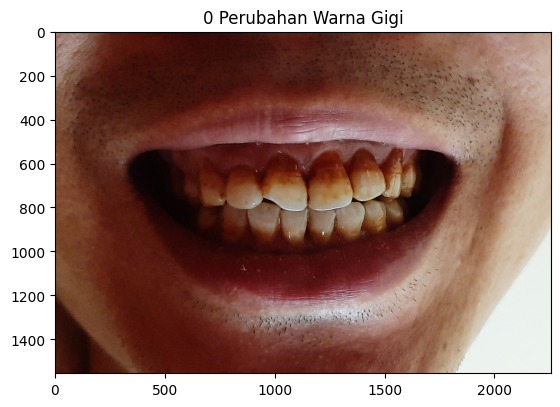

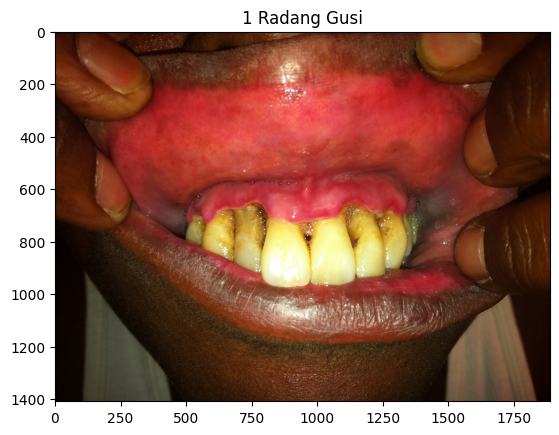

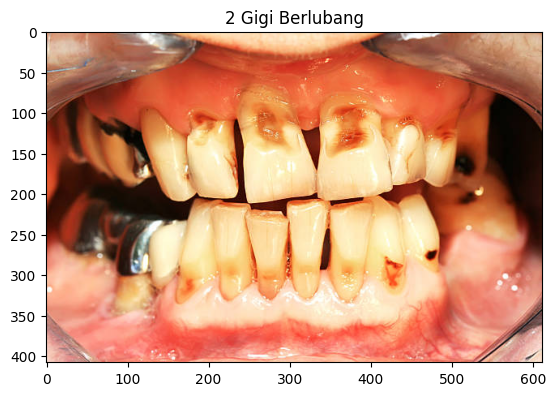

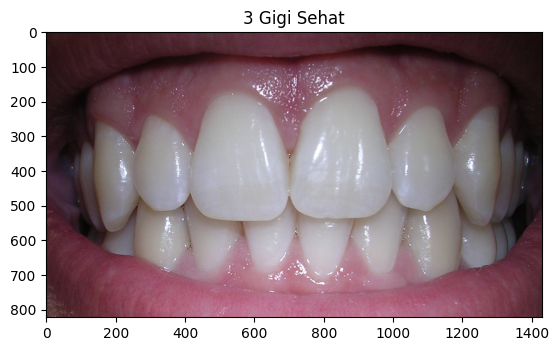

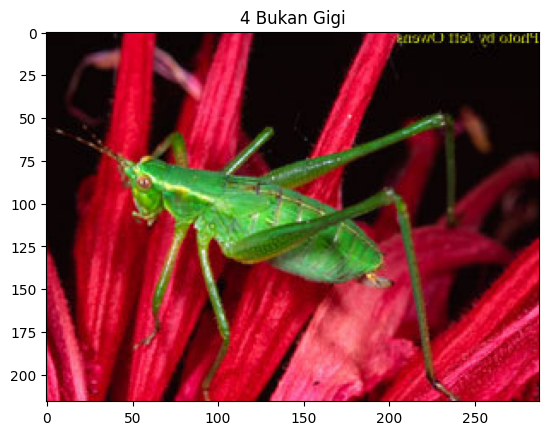

In [6]:
# Display sample images from each class
img_each_class = 1
img_samples = {}
classes = list(number_label.keys())

for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))
    if len(temp) >= img_each_class:
        for item in temp[:img_each_class]:
            img_path = os.path.join(base_dir, c, item)
            img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

In [7]:
# Define ImageDataGenerator parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
SEED = 999

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    fill_mode='nearest',
)

train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

print(f"Found {train_data.samples} images belonging to {train_data.num_classes} classes.")
print(f"Found {valid_data.samples} images belonging to {valid_data.num_classes} classes.")


Found 1641 images belonging to 5 classes.
Found 407 images belonging to 5 classes.
Found 1641 images belonging to 5 classes.
Found 407 images belonging to 5 classes.


In [8]:
# Define the hypermodel for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(224, 224, 3)))

    for i in range(hp.Int('conv_blocks', 2, 5, default=3)):
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Int(f'filters_{i}', 32, 256, step=32),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model.add(tf.keras.layers.MaxPooling2D(2, 2))

    model.add(tf.keras.layers.GlobalAveragePooling2D())
    
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', 128, 512, step=64),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))

    model.add(tf.keras.layers.Dense(5, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [9]:
# Initialize Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=2,
    directory='my_dir',
    project_name='intro_to_kt'
)

Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [10]:
# Search for the best hyperparameters
tuner.search(
    train_data,
    epochs=100,
    validation_data=valid_data,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)


In [11]:
# Retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 160)  │        46,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 160)    │       230,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 224)    │       322,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 224)    │       451,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 224)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 224)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │        72,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,605 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,893 (4.29 MB)

 Trainable params: 1,125,893 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Define callbacks
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.00001)
]


In [13]:
# Train the model
history = model.fit(
    train_data,
    epochs=100,
    validation_data=valid_data,
    steps_per_epoch=len(train_data) // BATCH_SIZE,
    validation_steps=len(valid_data) // BATCH_SIZE,
    callbacks=callbacks_list
)

Epoch 1/100


c:\Users\WIN 10\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.3646 - loss: 1.6612 - val_accuracy: 0.4201 - val_loss: 1.3817 - learning_rate: 7.0989e-04
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.4848 - loss: 1.2214 - val_accuracy: 0.5602 - val_loss: 1.1002 - learning_rate: 7.0989e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.5583 - loss: 1.0826 - val_accuracy: 0.5577 - val_loss: 1.0967 - learning_rate: 7.0989e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.5626 - loss: 1.0386 - val_accuracy: 0.5897 - val_loss: 1.0347 - learning_rate: 7.0989e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.5853 - loss: 1.0239 - val_accuracy: 0.6020 - val_loss: 0.9414 - learning_rate: 7.0989e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.5736 - loss: 0.9990 - val_accuracy: 0.6044 - val_loss: 1.0406 - learning_rate: 7.0989e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.6240 - loss: 0

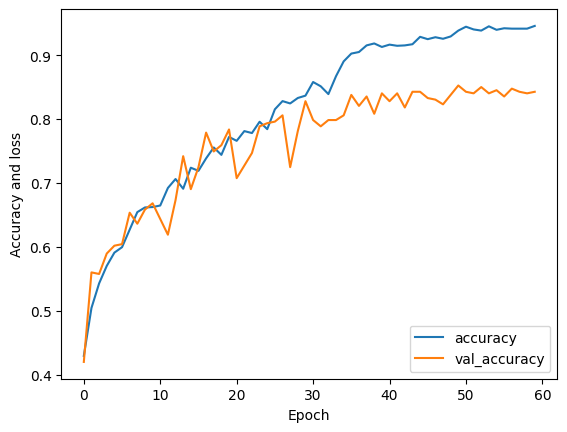

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy and loss')
plt.legend(loc='lower right')

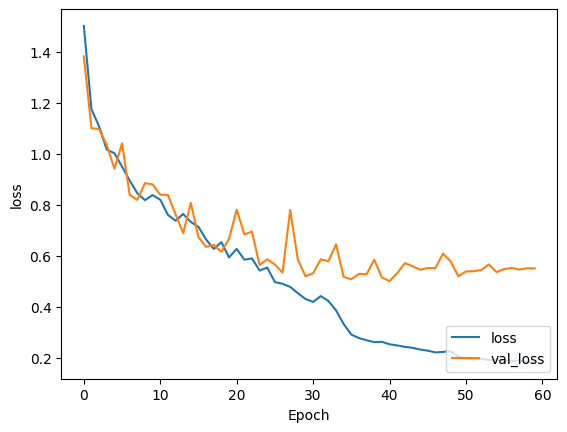

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')